# Calibration of the Rahmstorf (2007) SLR Model

## Load Environment

In [235]:
Pkg.activate(dirname(@__DIR__))
Pkg.instantiate()

  Activating project at `~/Teaching/BEE4850/website/slides`
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API /Users/vs498/.julia/juliaup/julia-1.10.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Pkg/src/API.jl:1807


Pkg.Types.PkgError: `XLSX` is a direct dependency, but does not appear in the manifest. If you intend `XLSX` to be a direct dependency, run `Pkg.resolve()` to populate the manifest. Otherwise, remove `XLSX` with `Pkg.rm("XLSX")`. Finally, run `Pkg.instantiate()` again.

In [211]:
using Distributions
using StatsBase
using CSV
using DataFrames
using Optim
using Turing
using Plots
using StatsPlots
using XLSX

ArgumentError: ArgumentError: Package XLSX [fdbf4ff8-1666-58a4-91e7-1b58723a45e0] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.


## Load Data

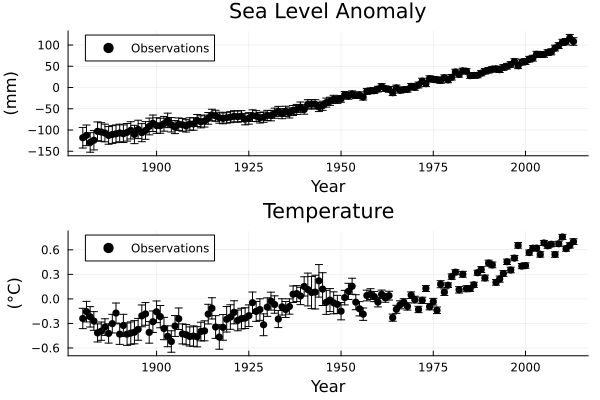

In [173]:
data_path = joinpath(dirname(@__DIR__), "data")
norm_yrs = 1951:1980

sl_dat = DataFrame(CSV.File(joinpath(data_path, "sealevel", "CSIRO_Recons_gmsl_yr_2015.csv")))

rename!(sl_dat, [:Year, :GMSLR, :SD]) # rename to make columns easier to work with
sl_dat[!, :Year] .-= 0.5 # shift year to line up with years instead of being half-year 
sl_dat[!, :GMSLR] .-= mean(filter(row -> row.Year ∈ norm_yrs, sl_dat)[!, :GMSLR]) # rescale to be relative to 1880-1900 mean for consistency with temperature anomaly

# load temperature data
temp_dat = DataFrame(CSV.File(joinpath(data_path, "climate", "HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv")))
rename!(temp_dat, [:Year, :Temp, :Lower, :Upper]) # rename to make columns easier to work with
filter!(row -> row.Year ∈ sl_dat[!, :Year], temp_dat) # reduce to the same years that we have SL data for
temp_normalize = mean(filter(row -> row.Year ∈ norm_yrs, temp_dat)[!, :Temp]) # get renormalization to rescale temperature to 1880-1900 mean
temp_dat[!, :Temp] .-= temp_normalize
temp_dat[!, :Lower] .-= temp_normalize
temp_dat[!, :Upper] .-=  temp_normalize

sl_plot = scatter(sl_dat[!, :Year], sl_dat[!, :GMSLR], yerr=sl_dat[!, :SD], color=:black, label="Observations", ylabel="(mm)", xlabel="Year", title="Sea Level Anomaly")

temp_plot = scatter(temp_dat[!, :Year], temp_dat[!, :Temp], yerr=(temp_dat[!, :Temp] - temp_dat[!, :Lower], temp_dat[!, :Upper] - temp_dat[!, :Temp]), color=:black, label="Observations", ylabel="(°C)", xlabel="Year", title="Temperature")

plot(sl_plot, temp_plot, layout=(2, 1))

## Model Specification

The Rahmstorf (2007) model is:

$$\frac{dH}{dt} = \alpha (T - T_0)$$

Discretizing:

$$H(t+1) = H(t) + \Delta t \alpha (T - T_0)$$

We'll set $\Delta t = 1 \text{yr}$. This means we need the following parameters:

- $\alpha$: SLR sensitivity to temperature anomalies $(mm/(yr \cdot ^\circ C))$,
- $T\_0$: Null temperature anomaly (no SLR at this temperature) $(^\circ C)$.
- $H_0 = H(0)$: Initial SL anomaly $(mm)$.

This is the **generative model**.

Simplest way to add residuals/measurement errors:

$$y_t \sim N(H(t), \sigma^2)$$

In [174]:
function rahmstorf_slr(params, temps; Δt=1)
    α, b, T₀, H₀ = params
    temp_diff = temps .- T₀
    ΔT = [0; diff(temps)]
    H = zeros(length(temps) + 1) # initialize storage
    H[1] = H₀
    for i = 2:length(H)
        H[i] = H[i-1] + α * Δt * temp_diff[i-1] + b * ΔT[i-1]
    end
    return H[2:end]
end

rahmstorf_slr (generic function with 2 methods)

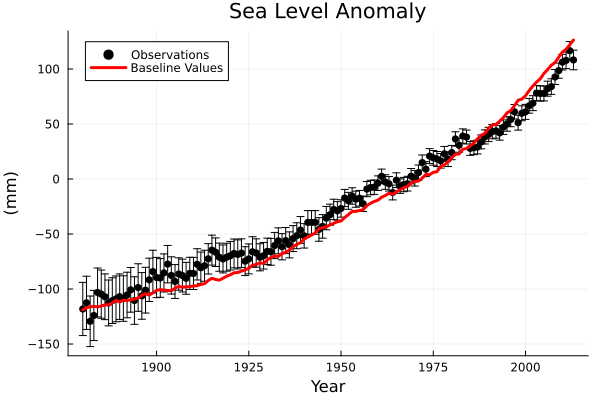

In [196]:
slr_ex = rahmstorf_slr((3.0, 8.0, -0.6, -120.0), temp_dat.Temp)
sl_plot = scatter(sl_dat[!, :Year], sl_dat[!, :GMSLR], yerr=sl_dat[!, :SD], color=:black, label="Observations", ylabel="(mm)", xlabel="Year", title="Sea Level Anomaly")
plot!(sl_plot, sl_dat[!, :Year], slr_ex, color=:red, linewidth=3, label="Baseline Values")

## Model Calibration 1: Gaussian iid Errors

In [191]:
# now the params include the standard deviation of the error model as well
function gaussian_iid_homosked(params, temp_dat, slr_dat, Δt=1.0)
    α, b, T₀, H₀, σ = params 
    slr_sim = rahmstorf_slr((α, b, T₀, H₀), temp_dat; Δt = Δt)
    ll = sum(logpdf.(Normal.(slr_sim, σ), slr_dat))
    return ll
end

gaussian_iid_homosked((4.6, 50.0, -0.5, -100.0, 5.0), temp_dat.Temp, sl_dat.GMSLR)

-8874.472323023905

In [192]:
low_bds = [0.0, -100.0, -5.0, -200.0, 0.0]
up_bds = [10.0, 100.0, 0.0, 0.0, 50.0]
p₀ = [3.4, 20.0, -0.5, -100.0, 10.0]

mle_optim = optimize(p -> -gaussian_iid_homosked(p, temp_dat.Temp, sl_dat.GMSLR), low_bds, up_bds, p₀)
p_mle = mle_optim.minimizer

5-element Vector{Float64}:
    1.9954491265469922
   -7.5317201796796605
   -0.8657256421723124
 -117.60853103602687
    5.8375424743684

In [194]:
rahmstorf_homogauss_mle = rahmstorf_slr(p_mle, temp_dat.Temp)


134-element Vector{Float64}:
 -116.35838317812792
 -115.57099317278791
 -113.80369210910764
 -112.230991078904
 -110.23454730600139
 -109.45392169229179
 -108.79168143326548
 -107.32002185084644
 -107.09601755182823
 -106.68952893218083
    ⋮
   81.02621423615516
   84.30750091694954
   87.22436356824912
   90.98330316578442
   93.0668769176982
   95.67532357714659
   99.70322536024302
  102.43559944210854
  105.21406676270963

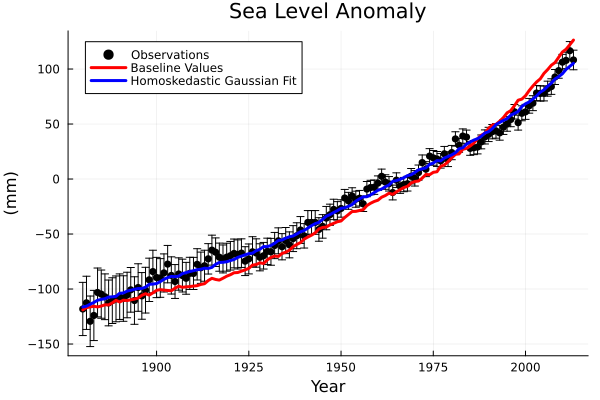

In [197]:
plot!(sl_plot, sl_dat[!, :Year], rahmstorf_homogauss_mle, color=:blue, linewidth=3, label="Homoskedastic Gaussian Fit")

In [200]:
function gaussian_iid_ar(params, temp_dat, slr_dat, slr_err, Δt=1.0)
    α, b, T₀, H₀, ρ, σ = params 
    slr_sim = rahmstorf_slr((α, b, T₀, H₀), temp_dat; Δt = Δt)
    # whiten residuals
    ll = 0
    residuals = zeros(length(slr_dat))
    for t in eachindex(slr_dat)
        residuals[t] = slr_dat[t] - slr_sim[t]
        if t == 1
            ll += logpdf(Normal(0, sqrt(σ^2 / (1 - ρ^2))), residuals[t])
        else
            ll += logpdf(Normal(ρ * residuals[t-1], σ), residuals[t])
        end
    end
    return ll
end


gaussian_iid_ar (generic function with 2 methods)

In [201]:
low_bds = [0.0, -100.0, -5.0, -200.0, -1.0, 0.0]
up_bds = [10.0, 100.0, 0.0, 0.0, 1.0, 50.0]
p₀ = [3.4, 20.0, -0.5, -100.0, 0.0, 10.0]

mle_optim = optimize(p -> -gaussian_iid_ar(p, temp_dat.Temp, sl_dat.GMSLR, sl_dat.SD), low_bds, up_bds, p₀)
p_mle2 = mle_optim.minimizer
@show p_mle;
@show p_mle2;

p_mle = [1.9954491265469922, -7.5317201796796605, -0.8657256421723124, -117.60853103602687, 5.8375424743684]
p_mle2 = [1.9302376511820256, -3.143145055240983, -0.8779630536816122, -117.15572156303162, 0.5274575062040584, 4.969822166300397]


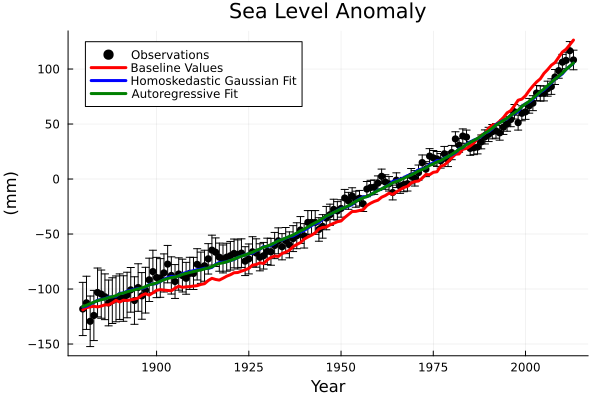

In [202]:
rahmstorf_ar_mle = rahmstorf_slr(p_mle2, temp_dat.Temp)
plot!(sl_plot, sl_dat[!, :Year], rahmstorf_ar_mle, color=:green, linewidth=3, label="Autoregressive Fit")

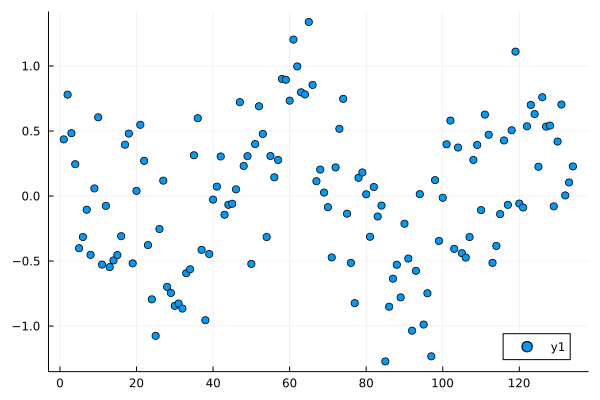

In [204]:
scatter(rahmstorf_ar_mle - rahmstorf_homogauss_mle)

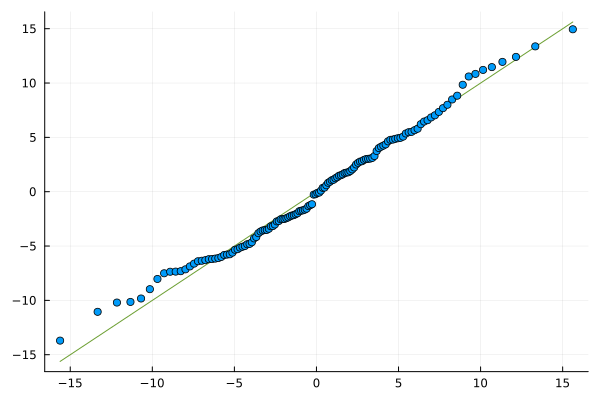

In [205]:
resids_homogauss = sl_dat.GMSLR - rahmstorf_homogauss_mle
qqnorm(resids_homogauss)


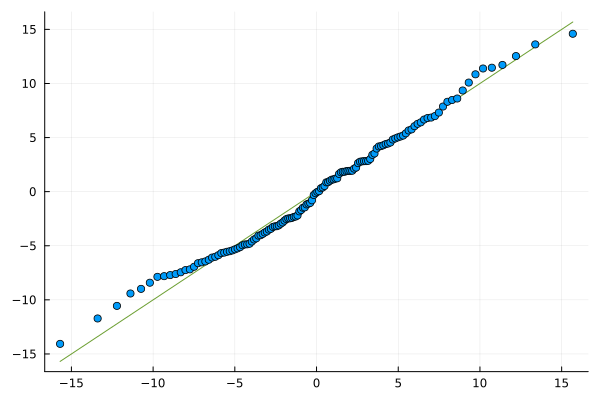

In [206]:
resids_ar = sl_dat.GMSLR - rahmstorf_ar_mle
qqnorm(resids_ar)

In [207]:
pacf_homogauss = pacf(resids_homogauss, 1:5)

5-element Vector{Float64}:
  0.5192505198498225
  0.08329400513333905
  0.01867936456698277
  0.04266165780753862
 -0.08903475090917588

In [208]:
pacf_ar = pacf(resids_ar, 1:5)

5-element Vector{Float64}:
  0.5308290425376294
  0.0917898388200087
  0.03511550852430468
  0.047473969055681735
 -0.07752525981548981

## Projections

In [225]:
cwd()


UndefVarError: UndefVarError: `cwd` not defined

In [ ]:

Pkg.update()
rcp26 = XLSX.readtable(joinpath(data_path, "climate", "cmip6_temps.xlsx")) |> DataFrame
